In [1]:
# Import all required packages

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import datetime as dt
from scipy import stats
import nltk
nltk.download()
%matplotlib inline
sns.set()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


#### Load dataset

In [2]:
# Read dataset csv file downloaded from Kaggle website

df = pd.read_csv(r"C:\Users\Adi\Desktop\Data_Science\Capstone\Capstone_1\DataSet.csv")

# Check the basic structure for all features

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


#### Data Wrangling

In [3]:
# Change column name

df.rename(columns = {'usd pledged':'usd_pledged'}, inplace=True)


In [4]:
# Check null values in each column

print('Frequency of null values \n')
print(df.isnull().sum())

print('\nTop 5 duplicate campaign names')
df.name.value_counts().head()

Frequency of null values 

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd_pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

Top 5 duplicate campaign names


New EP/Music Development      41
Canceled (Canceled)           13
Music Video                   11
N/A (Canceled)                11
New EP / Music Development    10
Name: name, dtype: int64

In [5]:
# Create a list to store boolean entries for if name column contains 'canceled' word
# Display the count of true (yes canceled in name value) or false

invalid_names = (df.name.str.contains('Canceled', case=False)) | (df.name.str.contains('Cancelled', case=False))
print(invalid_names.value_counts())

# Assigning false (where 'canceled' not present) list entries from invalid_names list

data = df[invalid_names == False]

False    355530
True      23131
Name: name, dtype: int64


In [6]:
# Check for null values

print('Total null values in name column: ', data.name.isnull().sum())

print('\nInconsistent data for the missing name rows\n')

Total null values in name column:  4

Inconsistent data for the missing name rows



In [7]:
# Reassign data frame without null value rows in name column

data = data.dropna(subset=['name'], how='any')

# Check for null values to confirm drop

data.name.isnull().sum()

0

In [8]:
# Filter dataframe without undefined state and assign it back to data

data = data[data.state != 'undefined']

In [9]:
# Drop rows with duplicate names

data = data.drop_duplicates(subset=['name'], keep=False)

In [10]:
df = data
# Drop null values
df.dropna(how='any', inplace=True)

In [11]:
# Convert columns from string to datetime

df['launched'] = pd.to_datetime(df.launched)
df['deadline'] = pd.to_datetime(df.deadline)

In [12]:
# Create new columns and pick values from launched date

df['year'] = df.launched.dt.year
df['day'] = df.launched.dt.dayofweek
df['month'] = df.launched.dt.month

# Duration in days is the difference between deadline and launched date
# Adding 1 to the difference as the actual days is 1 more than the difference

df['duration'] = (df['deadline'] - df['launched']).astype('timedelta64[D]') + 1

# Create new fetaures

df['p_timesgoal'] = df['usd_pledged_real'] / df['usd_goal_real']
df['p_perbacker'] = df['usd_pledged_real'] / df['backers']

# Replace inf value with NaN with zero
df[['p_perbacker']] = df[['p_perbacker']].replace([np.inf, -np.inf], np.nan).fillna(0)

# Convert new features to int dtype
df['p_timesgoal'] = df['p_timesgoal'].round(2)
df['p_perbacker'] = df['p_perbacker'].round(0).astype(int)

In [13]:
# Delete unwanted columns

del df['usd_pledged']
del df['ID']
del df['goal']
del df['pledged']
del df['currency']

In [14]:
# Drop any obervations before 2005

df = df[df.year >2005]

In [15]:
# Create two new working dataframes for successful and failed state

df['p_timesgoal'] = df['p_timesgoal'] * 100
df_failed = df[df['state'] == 'failed']
df_successful = df[df['state'] == 'successful']

c:\miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# Count monthly campaigns grouped by state

data = df.groupby(['month', 'state']).size().unstack('state')
data['Month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

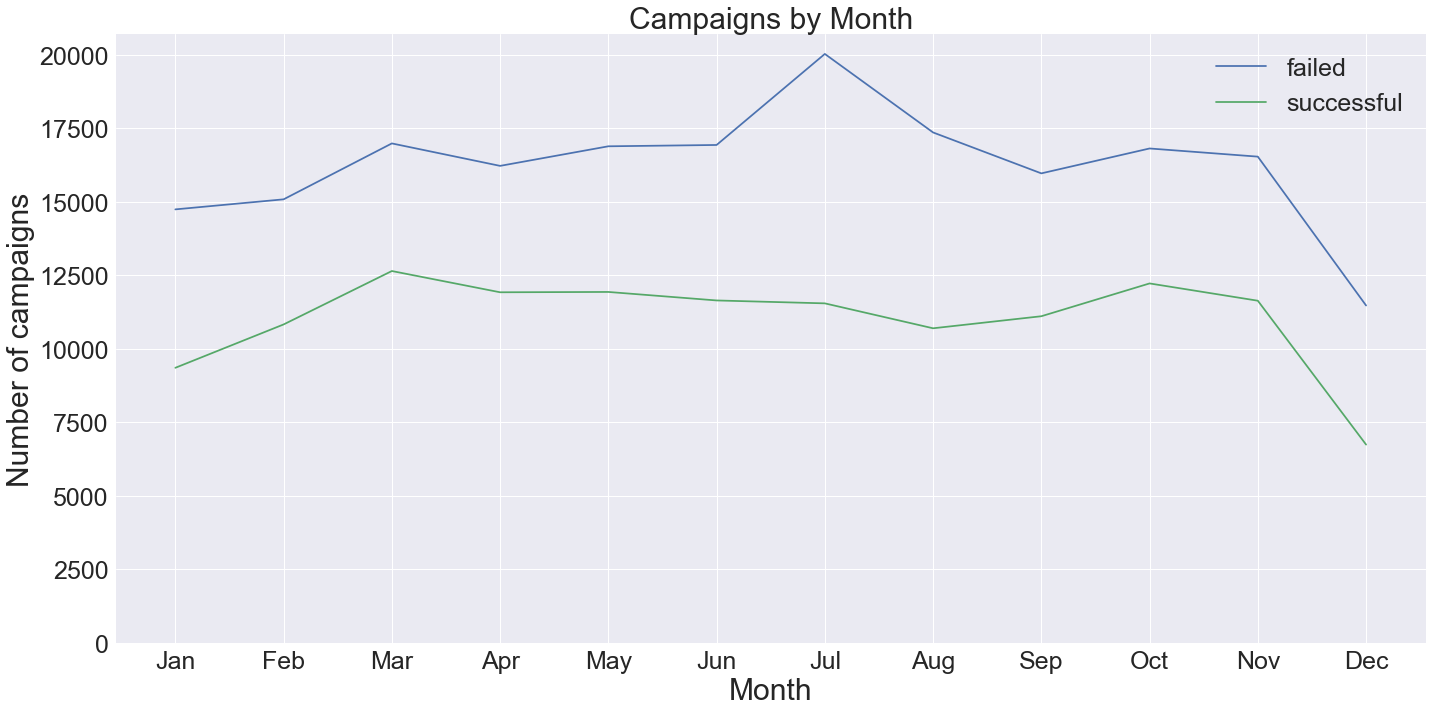

In [17]:
# Plot line chart for successful and failed campaigns
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(data['Month'], data['failed'])
ax.plot(data['Month'], data['successful'])
#ax.title('State grouped across months')
ax.legend(loc='upper right', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=25)
ax.set_title('Campaigns by Month', fontdict={'fontsize': 30})
ax.set_xlabel('Month', fontdict={'fontsize': 30})
ax.set_ylabel('Number of campaigns', fontdict={'fontsize': 30})
ax.set_ylim(0,)
fig.tight_layout()
plt.savefig('temp.png')

In [18]:
# Group data by year and month for successful and failed campaigns
s_yoy = df_successful.groupby(['month', 'year']).size().unstack('year')
f_yoy = df_failed.groupby(['month', 'year']).size().unstack('year')
# Group data by year and month for all campaigns, we might need this later. Just in case
yoy = df[(df.state == 'failed') | (df.state == 'successful')].groupby(['month', 'year']).size().unstack('year')
# Success ratio
s_ratio = s_yoy / (s_yoy + f_yoy)
s_ratio['Month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

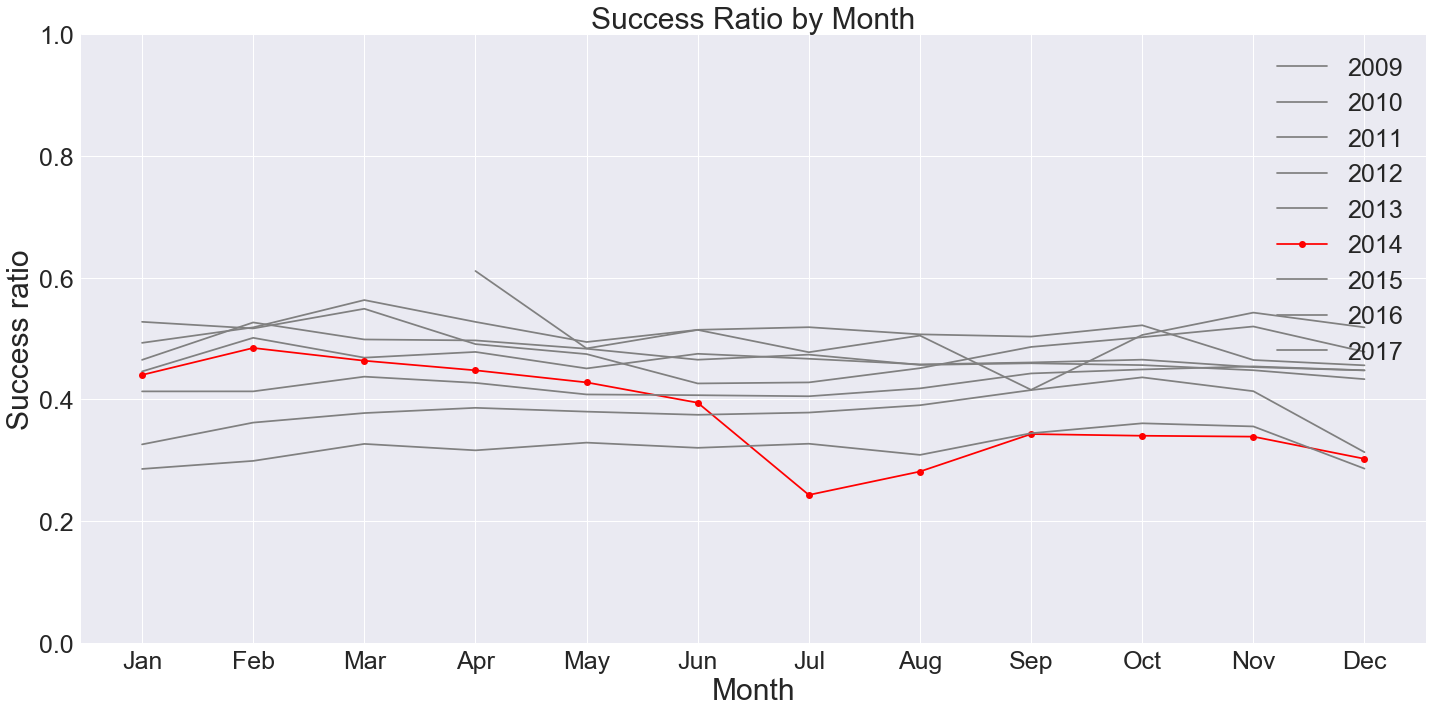

In [19]:
# Plot monthly s_ratio for all years 
fig, ax = plt.subplots(figsize=(20,10))
  
for i in range(9): 
    if i is 5:
        ax.plot(s_ratio['Month'], s_ratio[2009 + i], marker='o', color='r')
    else:
        ax.plot(s_ratio['Month'], s_ratio[2009 + i], 'grey')
ax.legend(loc='upper right', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=25)
ax.set_title('Success Ratio by Month', fontdict={'fontsize': 30})
ax.set_ylim(ymin=0, ymax=1)
ax.set_xlabel('Month', fontdict={'fontsize': 30})
ax.set_ylabel('Success ratio', fontdict={'fontsize': 30})
fig.tight_layout()
plt.savefig('temp.png')

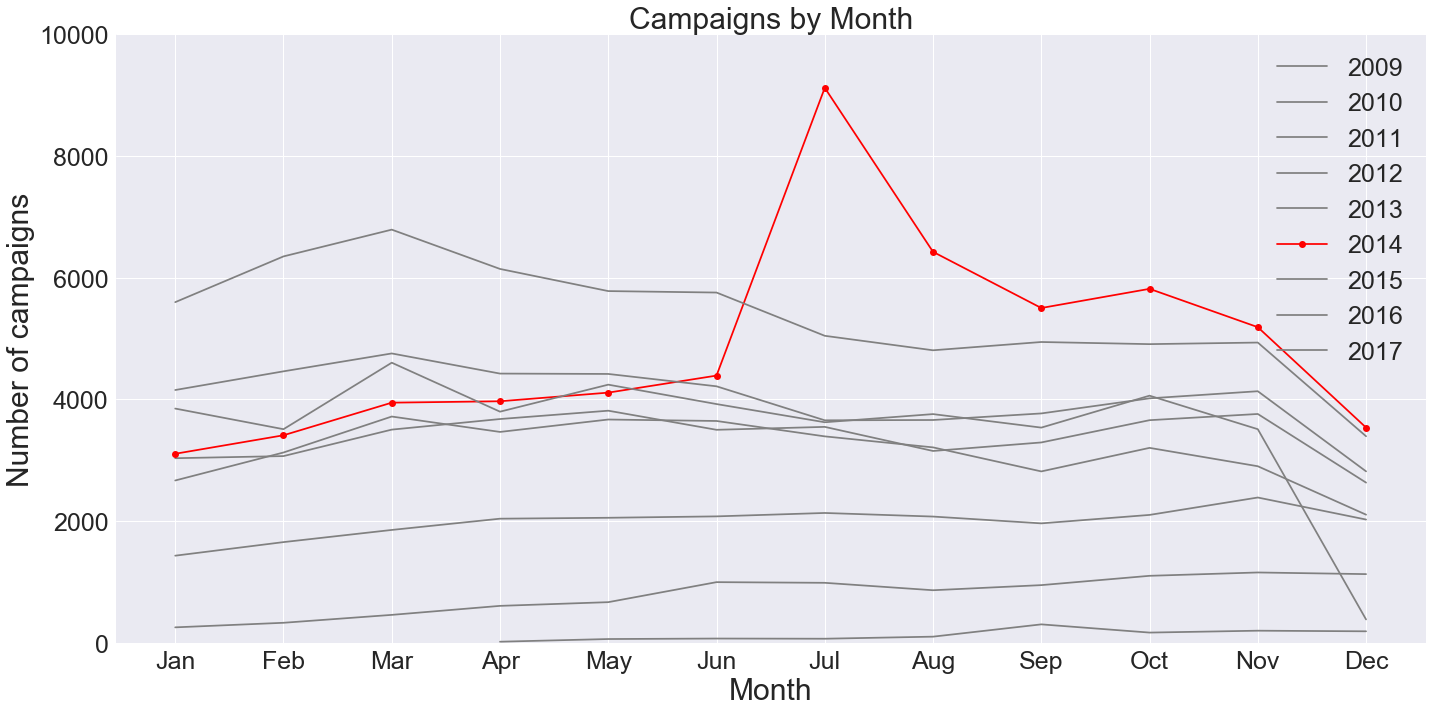

In [20]:
yoy['Month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot number of campaigns each month for all years

fig, ax = plt.subplots(figsize=(20,10))
for i in range(9): 
    if i is 5:
        ax.plot(yoy['Month'], yoy[2009 + i], marker='o', color='r')
    else:
        ax.plot(yoy['Month'], yoy[2009 + i], 'grey')
ax.legend(loc='upper right', fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=25)
ax.set_title('Campaigns by Month', fontdict={'fontsize': 30})
ax.set_ylim(ymin=0, ymax=10000)
ax.set_xlabel('Month', fontdict={'fontsize': 30})
ax.set_ylabel('Number of campaigns', fontdict={'fontsize': 30})
fig.tight_layout()
plt.savefig('temp.png')

In [21]:
countries = df[(df.state == 'failed') | (df.state == 'successful')].country.unique()
countries = countries.tolist()
length = len(countries)

In [22]:
data = df[(df.state == 'failed') | (df.state == 'successful')].groupby(['year', 'country']).size().unstack('country')
data.replace(np.nan, 0, inplace=True)
data_NA = data['US'] + data['CA'] + data['MX']
data_ANZ = data['AU'] + data['NZ']
data_EMEA = data['NO'] + data['IT'] + data['DE'] + data['IE'] + data['ES'] + data['SE'] + data['FR'] + data['CH'] + data['AT'] + data['BE'] + data['DK'] + data['HK'] + data['NL'] + data['LU'] + data['SG'] + data['JP']

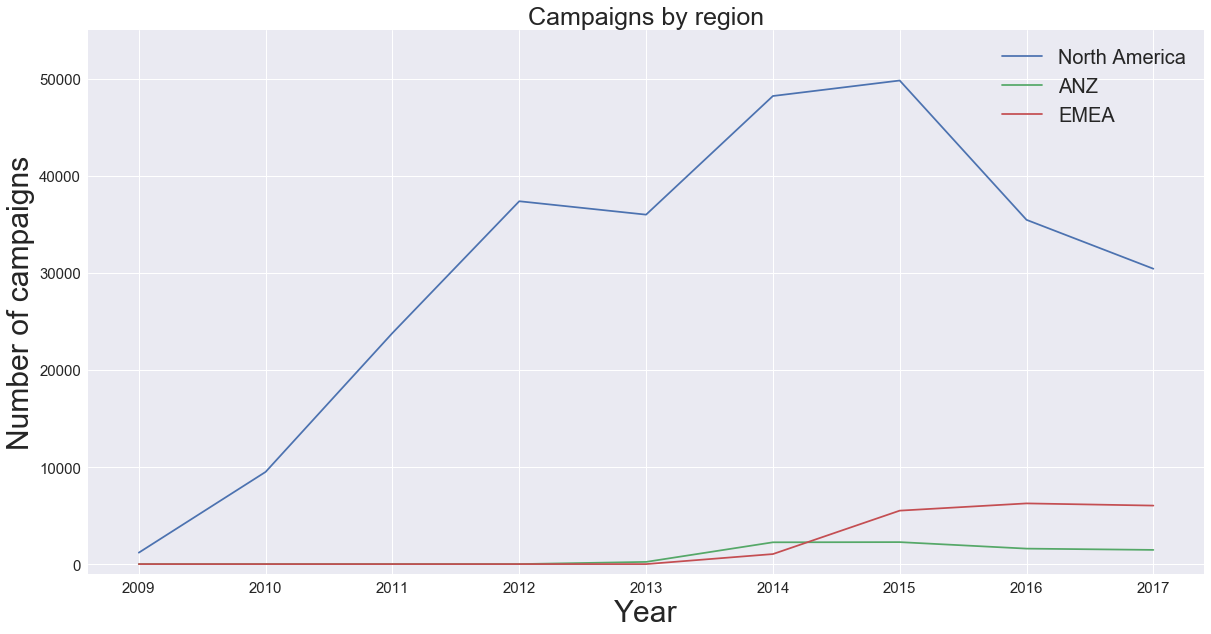

In [23]:
fig, ax1 = plt.subplots(figsize=(20,10))

ax1.plot(data_NA)
ax1.plot(data_ANZ)
ax1.plot(data_EMEA)

ax1.legend(('North America', 'ANZ', 'EMEA'), loc='upper right', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=15)
ax1.tick_params(axis='both', which='minor', labelsize=15)
ax1.set_title('Campaigns by region', fontdict={'fontsize': 25})
ax1.set_ylim(ymin=-1000, ymax=55000)
ax1.set_xlabel('Year', fontdict={'fontsize': 30})
ax1.set_ylabel('Number of campaigns', fontdict={'fontsize': 30})
plt.savefig('temp.png')

In [24]:
data = df[(df.state == 'successful') | (df.state == 'failed')]
data_NA = data[(data.country == 'US') | (data.country == 'CA') | (data.country == 'MX')]
data_ANZ = data[(data.country == 'AU') | (data.country == 'NZ')]
data_EMEA = data[(data.country == 'NO') | (data.country == 'IT') | (data.country == 'DE') | (data.country == 'IE') | (data.country == 'ES') | (data.country == 'SE') | (data.country == 'FR') | (data.country == 'CH') | (data.country == 'AT') | (data.country == 'BE') | (data.country == 'DK') | (data.country == 'HK') | (data.country == 'NL') | (data.country == 'LU') | (data.country == 'SG') | (data.country == 'JP')]

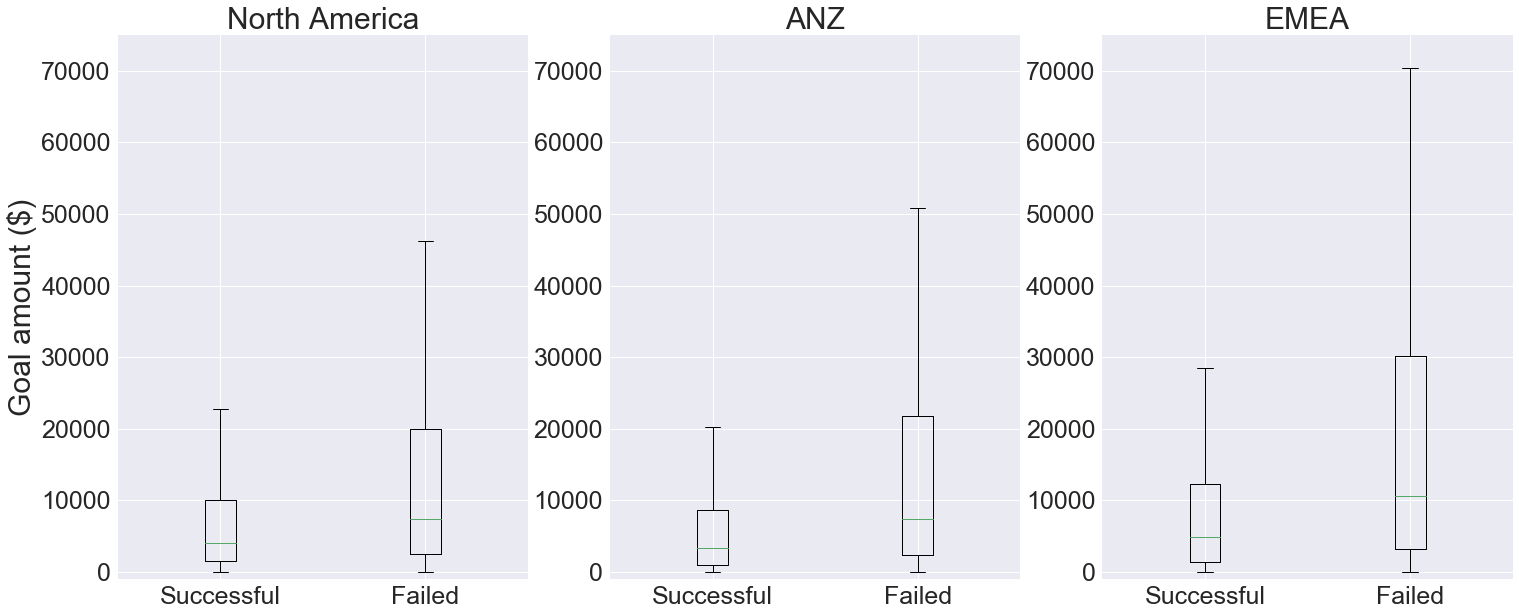

In [25]:
# Boxplot goal amount for successful and failed campaigns in each region

s_NA = data_NA[data_NA.state == 'successful']['usd_goal_real']
f_NA = data_NA[data_NA.state == 'failed']['usd_goal_real']
s_ANZ = data_ANZ[data_ANZ.state == 'successful']['usd_goal_real']
f_ANZ = data_ANZ[data_ANZ.state == 'failed']['usd_goal_real']
s_EMEA = data_EMEA[data_EMEA.state == 'successful']['usd_goal_real']
f_EMEA = data_EMEA[data_EMEA.state == 'failed']['usd_goal_real']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 10))

ax1.boxplot([s_NA, f_NA])
ax2.boxplot([s_ANZ, f_ANZ])
ax3.boxplot([s_EMEA, f_EMEA])
ax1.set_xticklabels(['Successful', 'Failed'])
ax1.tick_params(axis='both', which='major', labelsize=25)
ax1.tick_params(axis='both', which='minor', labelsize=25)
ax1.set_title('North America', fontdict={'fontsize': 30})
ax1.set_ylim(ymin=-1000, ymax=75000)
ax1.set_xlabel('', fontdict={'fontsize': 30})
ax1.set_ylabel('Goal amount ($)', fontdict={'fontsize': 30})

ax2.set_xticklabels(['Successful', 'Failed'])
ax2.tick_params(axis='both', which='major', labelsize=25)
ax2.tick_params(axis='both', which='minor', labelsize=25)
ax2.set_title('ANZ', fontdict={'fontsize': 30})
ax2.set_ylim(ymin=-1000, ymax=75000)
ax2.set_xlabel('', fontdict={'fontsize': 30})
#ax2.set_ylabel('Goal amount', fontdict={'fontsize': 20})

ax3.set_xticklabels(['Successful', 'Failed'])
ax3.tick_params(axis='both', which='major', labelsize=25)
ax3.tick_params(axis='both', which='minor', labelsize=25)
ax3.set_title('EMEA', fontdict={'fontsize': 30})
ax3.set_ylim(ymin=-1000, ymax=75000)
ax3.set_xlabel('', fontdict={'fontsize': 30})
#ax3.set_ylabel('Goal amount', fontdict={'fontsize': 20})
plt.savefig('temp.png')

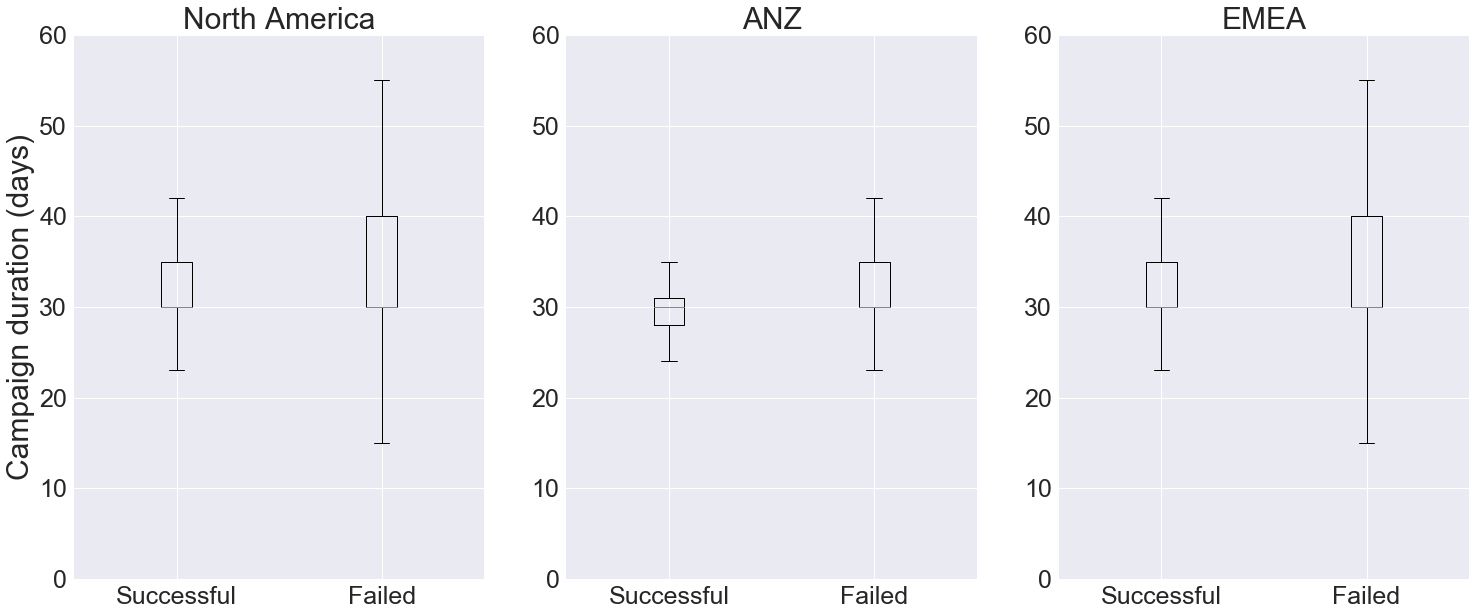

In [26]:
# Boxplot campaign duration for successful and failed campaigns in each region

s_NA = data_NA[data_NA.state == 'successful']['duration']
f_NA = data_NA[data_NA.state == 'failed']['duration']
s_ANZ = data_ANZ[data_ANZ.state == 'successful']['duration']
f_ANZ = data_ANZ[data_ANZ.state == 'failed']['duration']
s_EMEA = data_EMEA[data_EMEA.state == 'successful']['duration']
f_EMEA = data_EMEA[data_EMEA.state == 'failed']['duration']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 10))

ax1.boxplot([s_NA, f_NA])
ax2.boxplot([s_ANZ, f_ANZ])
ax3.boxplot([s_EMEA, f_EMEA])

ax1.set_xticklabels(['Successful', 'Failed'])
ax1.tick_params(axis='both', which='major', labelsize=25)
ax1.tick_params(axis='both', which='minor', labelsize=25)
ax1.set_title('North America', fontdict={'fontsize': 30})
ax1.set_ylim(ymin=0, ymax=60)
#ax1.set_xlabel('Year', fontdict={'fontsize': 20})
ax1.set_ylabel('Campaign duration (days)', fontdict={'fontsize': 30})

ax2.set_xticklabels(['Successful', 'Failed'])
ax2.tick_params(axis='both', which='major', labelsize=25)
ax2.tick_params(axis='both', which='minor', labelsize=25)
ax2.set_title('ANZ', fontdict={'fontsize': 30})
ax2.set_ylim(ymin=0, ymax=60)
#ax2.set_xlabel('Year', fontdict={'fontsize': 20})
#ax2.set_ylabel('Number of campaigns', fontdict={'fontsize': 20})

ax3.set_xticklabels(['Successful', 'Failed'])
ax3.tick_params(axis='both', which='major', labelsize=25)
ax3.tick_params(axis='both', which='minor', labelsize=25)
ax3.set_title('EMEA', fontdict={'fontsize': 30})
ax3.set_ylim(ymin=0, ymax=60)
#ax3.set_xlabel('Year', fontdict={'fontsize': 20})
#ax3.set_ylabel('Number of campaigns', fontdict={'fontsize': 20})
plt.savefig('temp.png')

In [27]:
df_successful = df[df.state == 'successful']
df_failed = df[df.state == 'failed']

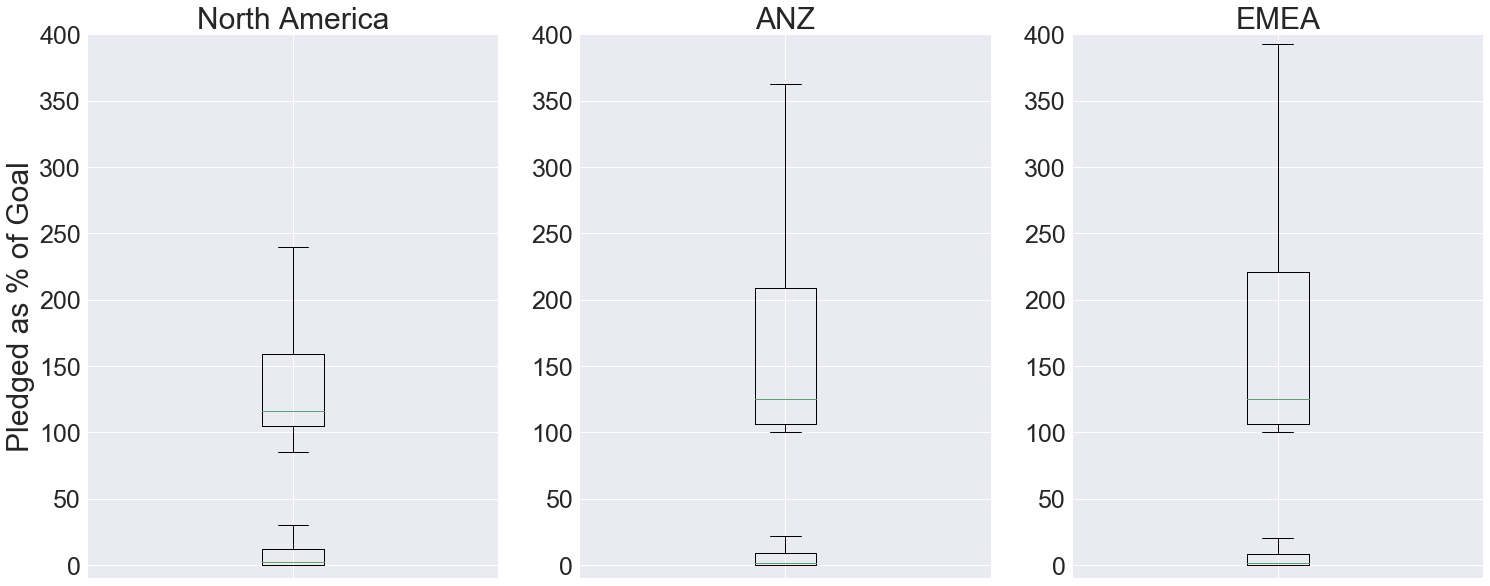

In [28]:
data = df[(df.state == 'successful') | (df.state == 'failed')]
data_NA = data[(data.country == 'US') | (data.country == 'CA') | (data.country == 'MX')]
data_ANZ = data[(data.country == 'AU') | (data.country == 'NZ')]
data_EMEA = data[(data.country == 'NO') | (data.country == 'IT') | (data.country == 'DE') | (data.country == 'IE') | (data.country == 'ES') | (data.country == 'SE') | (data.country == 'FR') | (data.country == 'CH') | (data.country == 'AT') | (data.country == 'BE') | (data.country == 'DK') | (data.country == 'HK') | (data.country == 'NL') | (data.country == 'LU') | (data.country == 'SG') | (data.country == 'JP')]

s_NA = data_NA[data_NA.state == 'successful']['p_timesgoal']
f_NA = data_NA[data_NA.state == 'failed']['p_timesgoal']
s_ANZ = data_ANZ[data_ANZ.state == 'successful']['p_timesgoal']
f_ANZ = data_ANZ[data_ANZ.state == 'failed']['p_timesgoal']
s_EMEA = data_EMEA[data_EMEA.state == 'successful']['p_timesgoal']
f_EMEA = data_EMEA[data_EMEA.state == 'failed']['p_timesgoal']

# Boxplot pleged amount as % of goal amount for successful and failed campaigns in each region

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(25, 10))

ax1.boxplot(s_NA)
ax1.boxplot(f_NA)
ax2.boxplot(s_ANZ)
ax2.boxplot(f_ANZ)
ax3.boxplot(s_EMEA)
ax3.boxplot(f_EMEA)

ax1.set_xticklabels('')
ax1.tick_params(axis='both', which='major', labelsize=25)
ax1.tick_params(axis='both', which='minor', labelsize=25)
ax1.set_title('North America', fontdict={'fontsize': 30})
ax1.set_ylim(ymin=-10, ymax=400)
#ax1.set_xlabel('Year', fontdict={'fontsize': 20})
ax1.set_ylabel('Pledged as % of Goal', fontdict={'fontsize': 30})

ax2.set_xticklabels('')
ax2.tick_params(axis='both', which='major', labelsize=25)
ax2.tick_params(axis='both', which='minor', labelsize=25)
ax2.set_title('ANZ', fontdict={'fontsize': 30})
ax2.set_ylim(ymin=-10, ymax=400)
#ax2.set_xlabel('Year', fontdict={'fontsize': 20})
#ax2.set_ylabel('Number of campaigns', fontdict={'fontsize': 20})

ax3.set_xticklabels('')
ax3.tick_params(axis='both', which='major', labelsize=25)
ax3.tick_params(axis='both', which='minor', labelsize=25)
ax3.set_title('EMEA', fontdict={'fontsize': 30})
ax3.set_ylim(ymin=-10, ymax=400)
#ax3.set_xlabel('Year', fontdict={'fontsize': 20})
#ax3.set_ylabel('Number of campaigns', fontdict={'fontsize': 20})
plt.savefig('temp.png')

In [29]:
# Create array to store sorted value for campaigns

x1 = np.sort(df[(df.state == 'failed')].p_timesgoal)
y1 = np.arange(1, len(x1) + 1) / len(x1)
y1 = y1 * 100

Text(0,0.5,'% Campaigns')

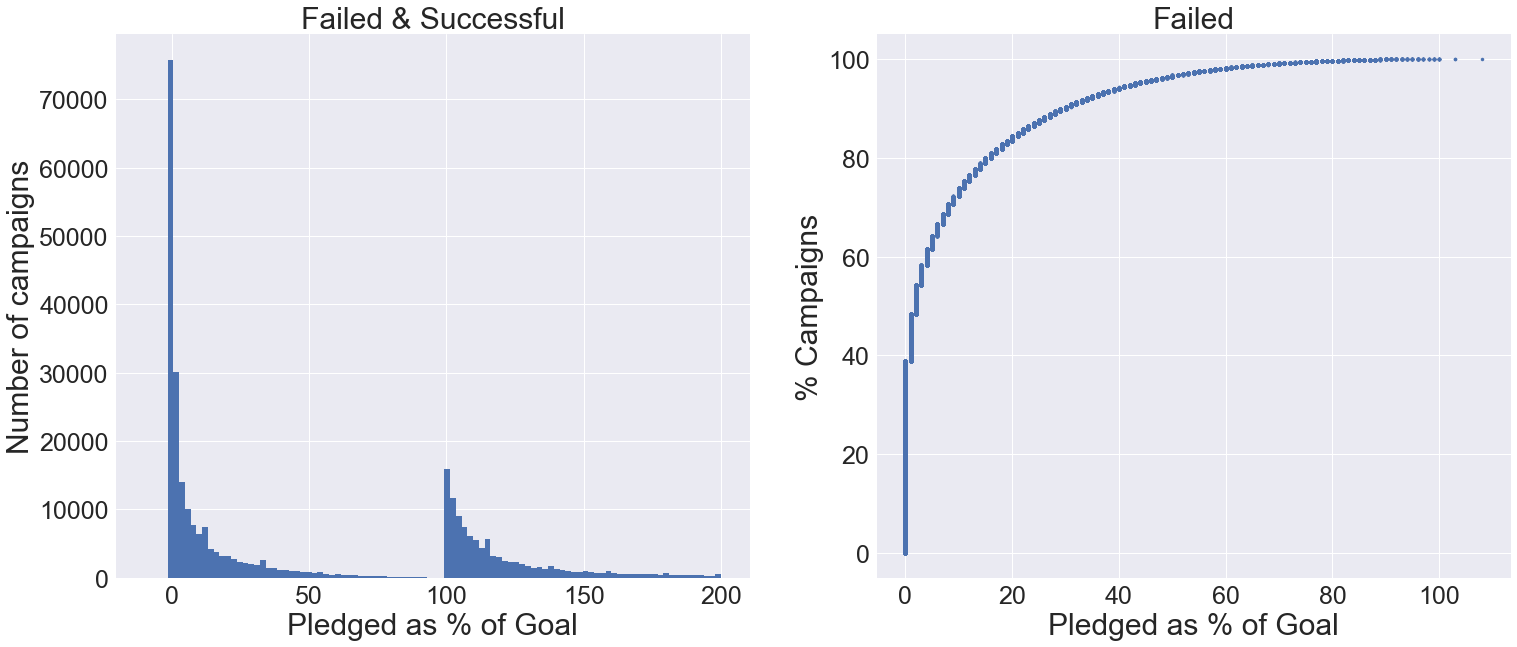

In [30]:
# Plot p_timesgoal histogram

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

ax1.hist(df[(df.state == 'successful') | (df.state == 'failed')].p_timesgoal, bins=100, range=(-10, 200))
ax2.plot(x1, y1, marker='.', linestyle='none')

#ax1.set_xticklabels('')
ax1.tick_params(axis='both', which='major', labelsize=25)
ax1.tick_params(axis='both', which='minor', labelsize=25)
ax1.set_title('Failed & Successful', fontdict={'fontsize': 30})
#ax1.set_ylim(ymin=-10, ymax=300)
ax1.set_xlabel('Pledged as % of Goal', fontdict={'fontsize': 30})
ax1.set_ylabel('Number of campaigns', fontdict={'fontsize': 30})

#ax1.set_xticklabels('')
ax2.tick_params(axis='both', which='major', labelsize=25)
ax2.tick_params(axis='both', which='minor', labelsize=25)
ax2.set_title('Failed', fontdict={'fontsize': 30})
#ax1.set_ylim(ymin=-10, ymax=300)
ax2.set_xlabel('Pledged as % of Goal', fontdict={'fontsize': 30})
ax2.set_ylabel('% Campaigns', fontdict={'fontsize': 30})

#### Statistical Analysis

Compare campaign duration and goal amount between successful & failed projects


In [31]:
# Create dataframe for failed and successful campaigns only
data = df[(df.state == 'failed') | (df.state == 'successful')]

# Create result column
# Result value 1 for successful, 0 for failed campaigns

data['result'] = pd.get_dummies(data.state).successful

c:\miniconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [32]:
# Create separate dataframe for failed and successful campaigns

f = df[df.state == 'failed']
s = df[df.state == 'successful']

In [33]:
# KS 2 sample test for duration
# Small pvalue signifies there difference in duration for failed and successful campaigns is statistically significant

stats.ks_2samp(f.duration.values, s.duration.values)

Ks_2sampResult(statistic=0.09900557408824556, pvalue=0.0)

In [34]:
# KS 2 sample test for goal amount
# Small pvalue signifies there difference in duration for failed and successful campaigns is statistically significant

stats.ks_2samp(f.usd_goal_real.values, s.usd_goal_real.values)

Ks_2sampResult(statistic=0.185409246869225, pvalue=0.0)

In [35]:
# Sprearman correlation test between duration and result
# This is non parametric test since data is not normally distributed

stats.spearmanr(data.duration.values.reshape(-1, 1), data.result.values.reshape(-1, 1))

SpearmanrResult(correlation=-0.09520977739439622, pvalue=0.0)

In [36]:
# Sprearman correlation test between goal amount and result
# This is non parametric test since data is not normally distributed

stats.spearmanr(data.usd_goal_real.values.reshape(-1, 1), data.result.values.reshape(-1, 1))

SpearmanrResult(correlation=-0.22167805064920165, pvalue=0.0)

In [37]:
# Define function to pick the best distribution of passed data from the list of distributions provided

def get_best_distribution(data):
    dist_names = ["gamma", "lognorm", "norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme", "expon"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(stats, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = stats.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [38]:
# Checking distribution for duration
# This is for re assurance

get_best_distribution(data.duration.values)

p value for gamma = 0.0
p value for lognorm = 0.0
p value for norm = 0.0
p value for exponweib = 0.0
p value for weibull_max = 0.0
p value for weibull_min = 0.0


c:\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for pareto = 0.0
p value for genextreme = 0.0
p value for expon = 0.0
Best fitting distribution: gamma
Best p value: 0.0
Parameters for the best fit: (11.09420426583413, -6.744007396250721, 3.669693596237975)


('gamma', 0.0, (11.09420426583413, -6.744007396250721, 3.669693596237975))

In [39]:
# Checking distribution for goal amount
# This is for re assurance

get_best_distribution(data.usd_goal_real.values)

p value for gamma = 0.0
p value for lognorm = 0.0
p value for norm = 0.0
p value for exponweib = 0.0
p value for weibull_max = 0.0
p value for weibull_min = 0.0


c:\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2305: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


p value for pareto = 0.0
p value for genextreme = 0.0
p value for expon = 0.0
Best fitting distribution: gamma
Best p value: 0.0
Parameters for the best fit: (0.001183762270934999, 166372354.61170137, 2.845057064315194e-16)


('gamma',
 0.0,
 (0.001183762270934999, 166372354.61170137, 2.845057064315194e-16))

In [40]:
# Null hypothesis: duration comes from same population for failed and successful projects
# Mann-Whitney U test

from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
# seed the random number generator
seed(1)
# generate two independent samples
data1 = s.duration.values
data2 = f.duration.values
# compare samples
stat, p = mannwhitneyu(data1, data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=11524324457.500, p=0.000
Different distribution (reject H0)


In [41]:
# Null hypothesis: usd_goal_real comes from same population for failed and successful projects
# Mann-Whitney U test

from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
# seed the random number generator
seed(1)
# generate two independent samples
data1 = s.usd_goal_real.values
data2 = f.usd_goal_real.values
# compare samples
stat, p = mannwhitneyu(data1, data2)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=9538791216.000, p=0.000
Different distribution (reject H0)


In [42]:
# Correlation matrix for entire dataframe

corr = data.corr()
corr

,backers,usd_pledged_real,usd_goal_real,year,day,month,duration,p_timesgoal,p_perbacker,result
backers,1.000000,0.752721,0.005198,0.019947,-0.029223,-0.002673,0.000016,0.016238,0.017579,0.125847
usd_pledged_real,0.752721,1.000000,0.006352,0.025291,-0.026826,-0.000232,0.008620,0.008905,0.093371,0.108412
usd_goal_real,0.005198,0.006352,1.000000,0.012201,-0.002551,0.001318,0.021328,-0.000432,0.013660,-0.023683
year,0.019947,0.025291,0.012201,1.000000,-0.033386,-0.091069,-0.171648,0.004520,0.006229,-0.073998
day,-0.029223,-0.026826,-0.002551,-0.033386,1.000000,-0.017698,0.019457,-0.000380,-0.006841,-0.021042
month,-0.002673,-0.000232,0.001318,-0.091069,-0.017698,1.000000,-0.017327,0.002779,0.013351,-0.010182
duration,0.000016,0.008620,0.021328,-0.171648,0.019457,-0.017327,1.000000,0.002740,0.021474,-0.115901
p_timesgoal,0.016238,0.008905,-0.000432,0.004520,-0.000380,0.002779,0.002740,1.000000,0.000513,0.014688
p_perbacker,0.017579,0.093371,0.013660,0.006229,-0.006841,0.013351,0.021474,0.000513,1.000000,0.155430
result,0.125847,0.108412,-0.023683,-0.073998,-0.021042,-0.010182,-0.115901,0.014688,0.155430,1.000000


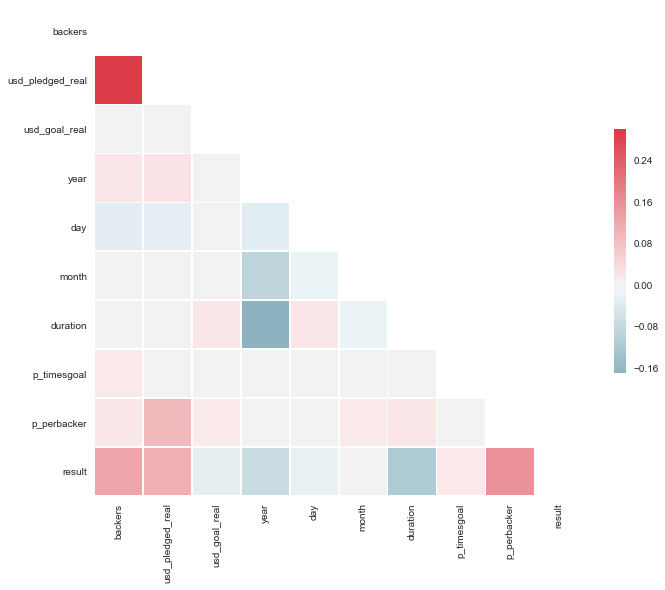

In [43]:
# Correlation heat map

from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")


# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [44]:
# NLP on name feature

data.to_csv('DataSet_clean.csv', index=False)

In [45]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score


In [46]:
data['result'] = (data.state == 'successful').astype(int)

df = data[['name', 'result']]

c:\miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [47]:
# Run model on filtered data - cap1

X = data['name'].values
y = data['result'].values

In [48]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    failed = y == 0
    successful = ~failed
    return prob[failed, 0].sum() + prob[successful, 1].sum()

from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(X.shape[0]), train_size=0.7)
mask = np.zeros(X.shape[0], dtype=np.bool)
mask[itest] = True



c:\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [49]:
from sklearn.naive_bayes import MultinomialNB

#the grid of parameters to search over

alphas = [0.1, 0.5, 1, 5, 10, 20, 50]
min_df = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30] # YOUR TURN: put your value of min_df here.

#Find the best value for alpha and min_df, and the best classifier
best_min_df = None
best_alpha = None
maxscore = -np.inf
score = None

#for min_df in min_df:
for alpha in alphas:        
        
        # Create the token pattern: TOKENS_ALPHANUMERIC
        TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+' 
        
        #TOKENS_ALPHANUMERIC = '[^\d\W\_\-\:\;\!\@\#\%\&\*\?]+' 
        vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern=TOKENS_ALPHANUMERIC)
        
        #vectorizer = TfidfVectorizer(ngram_range=(1,1), stop_words='english', token_pattern=TOKENS_ALPHANUMERIC, min_df=1)
        
        # Convert whole X into cv
        X_v = vectorizer.fit_transform(X)

        Xtrainthis = X_v[mask]
        ytrainthis = y[mask]
    
        # your turn
        clf = MultinomialNB(alpha=alpha)
        #clf = LogisticRegression(penalty='l2', C=alpha)
        score = cv_score(clf, Xtrainthis, ytrainthis, clf.score)
        
        if score > maxscore:
            vec = vectorizer
            classifier = clf
            maxscore = score
            best_alpha = alpha
            best_min_df = min_df
            
print('CV score:', maxscore)
print('aplha:', best_alpha)
print('min_df:', best_min_df)

CV score: 0.6455751521814328
aplha: 1
min_df: [1, 2, 3, 4, 5, 10, 15, 20, 25, 30]


In [50]:
# Run the best model

X_v = vec.fit_transform(X)
xtrain=X_v[mask]
ytrain=y[mask]
xtest=X_v[~mask]
ytest=y[~mask]

classifier = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = classifier.score(xtrain, ytrain)
test_accuracy = classifier.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.924924
Accuracy on test data:     0.649039


In [51]:
from sklearn.decomposition import PCA, TruncatedSVD

In [52]:
NLP_predict = classifier.predict(X_v)


In [53]:
pca = TruncatedSVD(n_components = 2)
pca.fit(X_v)

reduced_feature1 = pca.transform(X_v)[:,0]
reduced_feature2 = pca.transform(X_v)[:,1]

result = data.result.values

data_pca = pd.DataFrame({'result': result, 'NLP_predict': NLP_predict, 'reduced_feature1': reduced_feature1, 'reduced_feature2': reduced_feature2})
data_pca.head()

,result,NLP_predict,reduced_feature1,reduced_feature2
0,0,0,1.162585,-0.211952
1,0,0,0.107712,0.109569
2,0,0,0.018483,0.019360
3,0,0,0.145402,0.144903
4,1,1,0.002196,0.001383


In [54]:
data.head()

,name,category,main_category,deadline,launched,state,backers,country,usd_pledged_real,usd_goal_real,year,day,month,duration,p_timesgoal,p_perbacker,result
0,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-10-09,2015-08-11 12:12:28,failed,0,GB,0.0,1533.95,2015,1,8,59.0,0.0,0,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,15,US,2421.0,30000.00,2017,5,9,60.0,8.0,161,0
2,Where is Hank?,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,3,US,220.0,45000.00,2013,5,1,45.0,0.0,73,0
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-04-16,2012-03-17 03:24:11,failed,1,US,1.0,5000.00,2012,5,3,30.0,0.0,1,0
5,Monarch Espresso Bar,Restaurants,Food,2016-04-01,2016-02-26 13:38:27,successful,224,US,52375.0,50000.00,2016,4,2,35.0,105.0,234,1


In [55]:
df_final = data[['result']]

In [56]:
df_final.loc[:,'finish_month'] = data.loc[:,'deadline'].dt.month
df_final.loc[:,'finish_day'] = data.loc[:,'deadline'].dt.dayofweek

df_final.loc[:,'start_month'] = data.loc[:,'launched'].dt.month
df_final.loc[:,'category'] = data.loc[:,'category']
df_final.loc[:,'main_category'] = data.loc[:,'main_category']
df_final.loc[:,'country'] = data.loc[:,'country']
df_final.loc[:,'year'] = data.loc[:,'year']
df_final.loc[:,'duration'] = data.loc[:,'duration']
df_final.loc[:,'goal'] = data.loc[:,'usd_goal_real']

c:\miniconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\miniconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [57]:
df_final.head()

,result,finish_month,finish_day,start_month,category,main_category,country,year,duration,goal
0,0,10,4,8,Poetry,Publishing,GB,2015,59.0,1533.95
1,0,11,2,9,Narrative Film,Film & Video,US,2017,60.0,30000.00
2,0,2,1,1,Narrative Film,Film & Video,US,2013,45.0,45000.00
3,0,4,0,3,Music,Music,US,2012,30.0,5000.00
5,1,4,4,2,Restaurants,Food,US,2016,35.0,50000.00


In [58]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [59]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['finish_month', 'finish_day', 'start_month', 'duration', 'goal']
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),('scaler', StandardScaler())])

categorical_features = ['category', 'main_category', 'country', 'year']
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                               ('cat', categorical_transformer, categorical_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
#clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', LogisticRegression(solver='newton-cg'))])
#clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier())])
clf = Pipeline(steps=[('preprocessor', preprocessor), 
                      ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0))])

X = df_final.drop('result', axis=1)
y = df_final['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#param_grid = {'preprocessor__num__imputer__strategy': ['mean', 'median'], 'classifier__C': [0.1, 1.0, 10, 100]}
#grid_search = GridSearchCV(clf, param_grid, cv=5, iid=False)
#grid_search.fit(X_train, y_train)
#print(("best logistic regression from grid search: %.3f" % grid_search.score(X_test, y_test)))

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.681


In [60]:
predict = clf.predict(X)

In [61]:
model_predict = pd.DataFrame({'result': result, 'NLP_predict': NLP_predict, 'predict': predict})

In [62]:
model_predict.head()

,result,NLP_predict,predict
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,1,1,0
